# Explore_SOF_dataset

**Background: **In Chapter 7 of the Regression Methods in Biostats book, they introduce a longitudinal dataset called the Study of Osteoporotic Fractures. This study had over 7k units in the sample and tracked health habits, with a response of osteoporosis and breast cancer to name a few. In order to see how I would analyze the dataset before being biased by the book's tutorial, I want to explore the dataset a bit. 

**Purpose: **To explore the SOF dataset and try to fit the responses using methods I currently know

**Methods: **First, I will load the dataset. Then, I will format it by adding/changing column labels. Then, I will explore the variables by doing a describe on the dataset, plot 1D histograms, and plot 2D histograms using a pairplot function. After that, I will perform some fits of the response variables using a basic linear model and then a random forest model. Finally, I will plot my $R^2$ and RMSE using these methods. 

**Conclusions: **
* Fitting a multi-level model with patient id as a level has an r2 of ~0.92

# Inits

## Imports

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context='notebook', font_scale=1.5)


## Definitions

## Funcs

# Load the dataset

In [5]:
raw_df = pd.read_csv('./data/sof.csv')

# Format by adding/changing column labels

The column descriptions are as follows:
* id: Subject ID
* visit: Visit number
* totbmd: Bone mineral density
* nbmd: ???
* vdate: Visit date
* v2date: First visit date
* bmi: body mass index
* n_iadl: Numer of impaired instrumental activities of daily living
* age: Current age of subject
* meno_age: Age at menopause
* del_totbmd: ???
* base_totbmd: Bone mineral density at baseline

First, I will make `id` string type

In [6]:
raw_df['id'] = raw_df['id'].astype(str)

In [7]:
raw_df.head()

,id,visit,totbmd,nbmd,vdate,v2date,bmi,n_iadl,age,meno_age,del_totbmd,base_totbmd
0,10001,2,1.0857,0.9820,03/20/89,03/20/89,30.0,1.0,67.0,50.0,NaN,1.0857
1,10001,4,1.1010,0.9860,09/10/92,03/20/89,28.0,1.0,67.0,50.0,NaN,1.0857
2,10001,5,1.1060,0.9770,05/02/96,03/20/89,30.0,1.0,67.0,50.0,NaN,1.0857
3,10001,6,1.0419,0.9055,12/11/98,03/20/89,28.0,2.0,67.0,50.0,NaN,1.0857
4,10001,8,NaN,NaN,NaN,NaN,NaN,NaN,67.0,50.0,NaN,1.0857


# Explore variables by doing a describe on the dataset

In [8]:
raw_df.describe()

,visit,totbmd,nbmd,bmi,n_iadl,age,meno_age,del_totbmd,base_totbmd
count,42950.000000,27402.000000,27382.000000,26829.000000,27119.000000,42775.000000,35020.000000,13060.000000,41065.000000
mean,5.000000,0.735176,0.631839,26.417943,0.789299,73.392636,48.016705,-0.045512,0.746975
std,2.000023,0.133630,0.116722,4.697549,1.241180,5.089214,5.723567,0.068761,0.128768
min,2.000000,0.181000,0.172000,13.000000,0.000000,67.000000,14.000000,-0.346200,0.300000
25%,4.000000,0.645900,0.552000,23.000000,0.000000,69.000000,45.000000,-0.085225,0.659200
50%,5.000000,0.728600,0.621000,26.000000,0.000000,72.000000,49.000000,-0.042300,0.740700
75%,6.000000,0.817000,0.698275,29.000000,1.000000,76.000000,52.000000,-0.002600,0.826800
max,8.000000,1.655300,1.635000,54.000000,5.000000,99.000000,68.000000,0.754900,1.403000


This shows me that `visit`, `age`, and `base_totbmd` are the most filled in variables. `totbmd` in comparison, only has a 50% coverage. Same with `bmi` and `n_iadl` (number of impaired instrumental daily activities). 

Furthermore, only ~83% of subjects have a `meno_age` value. This may be because they had not gone through menopause. 

# Plot 1D histograms

In [9]:
raw_df.head(2)

,id,visit,totbmd,nbmd,vdate,v2date,bmi,n_iadl,age,meno_age,del_totbmd,base_totbmd
0,10001,2,1.0857,0.982,03/20/89,03/20/89,30.0,1.0,67.0,50.0,NaN,1.0857
1,10001,4,1.1010,0.986,09/10/92,03/20/89,28.0,1.0,67.0,50.0,NaN,1.0857


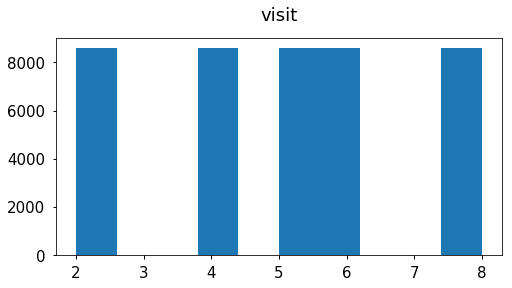

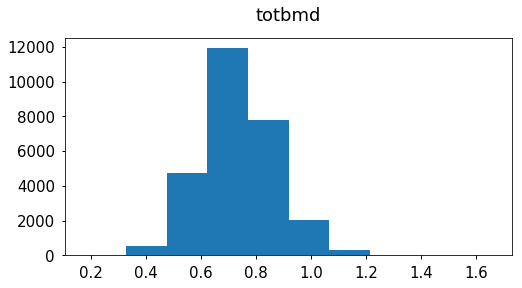

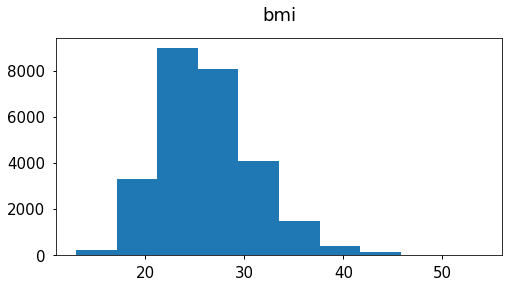

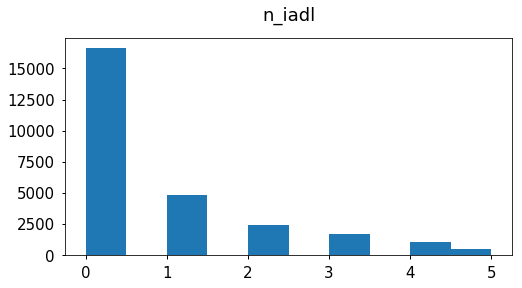

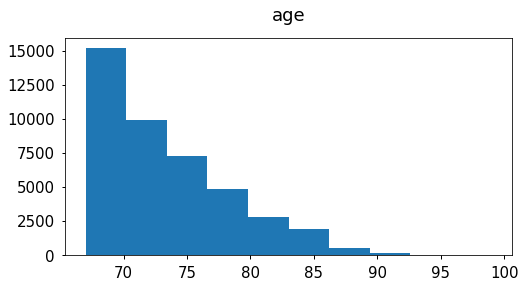

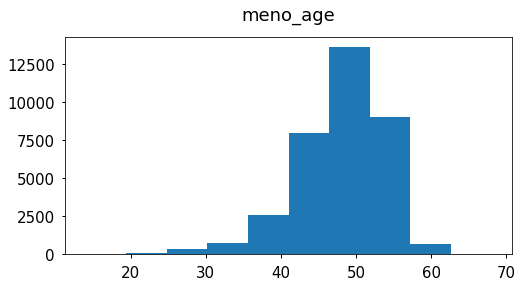

In [114]:
vars_to_plot = ['visit','totbmd','bmi','n_iadl','age','meno_age']

for curr_var in vars_to_plot:
    plt.figure(figsize=(8,4))
    plt.hist(raw_df[curr_var].dropna())
    
    ax = plt.gca()
    ax.set_title(curr_var, y=1.05)

# Plot 2D histograms using a pairplot function

In [ ]:
vars_to_plot = ['totbmd','bmi','n_iadl','age','meno_age']
sns.pairplot(data = raw_df.dropna(subset = vars_to_plot), 
             vars=vars_to_plot)

* `totbmd` has a slightly negative relationship with `age`
* `totbmd` has a positive relationship with `BMI`
* `totbmd` doesn't have a strong relationship with `meno_age` but is quite heteroskedastic with `meno_age`

# Perform some fits of the response variables 

## Format data into design matrix and response vector

I will need to drop all rows that have NaN before creating X and y matrices

In [23]:
df = raw_df.dropna(subset = ['bmi','n_iadl','age','meno_age'])

In [38]:
X_no_dummies = df[['id','bmi','n_iadl','age','meno_age']]
y = df[['totbmd']]

For the X variable, I need to create dummies for id

In [42]:
X = pd.concat([X_no_dummies.drop(['id'], axis=1), 
              pd.get_dummies(X_no_dummies['id'])],
              axis=1)

In [45]:
X.head(5)

,bmi,n_iadl,age,meno_age,10001,10002,10003,10004,10005,10006,...,42474,42475,42476,42478,42479,42481,42482,42483,42484,42486
0,30.0,1.0,67.0,50.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,28.0,1.0,67.0,50.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30.0,1.0,67.0,50.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,28.0,2.0,67.0,50.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,24.0,0.0,69.0,53.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Basic linear model

In [46]:
import sklearn.linear_model as skl_lm
import sklearn.model_selection as skl_ms
ridge_regr = skl_lm.Ridge()

In [58]:
ts_cv_split = skl_ms.TimeSeriesSplit(n_splits=4)

In [68]:
full_pred_results = pd.DataFrame()
for curr_visit in df['visit'].unique()[1:]:
    
    curr_train_indexes = df.loc[
        df['visit'] < curr_visit
    ].index
    
    curr_test_indexes = df.loc[
        df['visit'] == curr_visit
    ].index
    
    X_train = X.loc[curr_train_indexes]
    y_train = y.loc[curr_train_indexes]
    
    X_test = X.loc[curr_test_indexes]
    curr_results = df.loc[curr_test_indexes]
    
    ridge_regr.fit(X_train, y_train)
    
    curr_results['y_pred_ridge'] = ridge_regr.predict(X_test)
    
    full_pred_results = pd.concat([full_pred_results,
                                   curr_results])

In [67]:
full_pred_results.head()

,id,visit,totbmd,nbmd,vdate,v2date,bmi,n_iadl,age,meno_age,del_totbmd,base_totbmd,y_pred_ridge
1,10001,4,1.101,0.986,09/10/92,03/20/89,28.0,1.0,67.0,50.0,NaN,1.0857,0.929756
6,10002,4,0.486,0.320,09/17/93,02/17/89,24.0,0.0,69.0,53.0,NaN,0.5026,0.627669
16,10004,4,0.652,0.612,09/04/92,03/03/89,29.0,2.0,85.0,53.0,NaN,0.6980,0.691266
21,10005,4,0.981,0.696,09/04/92,03/03/89,36.0,2.0,77.0,53.0,NaN,0.9473,0.892278
26,10006,4,1.053,0.832,11/06/92,04/25/89,29.0,0.0,75.0,48.0,-0.0835,1.0303,0.898110


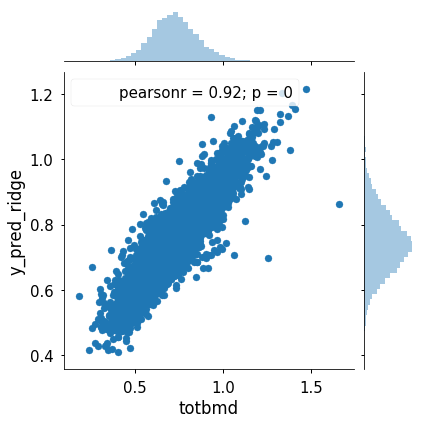

In [71]:
sns.jointplot(x='totbmd', y='y_pred_ridge', data=full_pred_results)
#df.plot('totbmd', 'y_pred_ridge', kind='scatter', alpha=0.3)

**This fit is quite good. I'm curious if the fit gets better as the number of visits increase, since the training data would be larger for later visits.**

### Does the fit get better with increasing visit number?

For this, I will calculate the mse for each row and then plot the mse vs. visit number to see if there is a negative relationship between the two

Calculate mae for each entry

In [81]:
full_pred_results['mae'] = np.abs(full_pred_results['y_pred_ridge'] - full_pred_results['totbmd'])

Plot mae vs. visit number 

(-0.03965807456872012, 0.2)

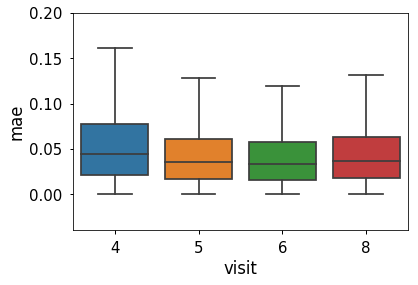

In [88]:
sns.boxplot(x='visit', y='mae', data=full_pred_results, fliersize=False)
ax = plt.gca()
ax.set_ylim(top=0.2)

This shows an ever so slight decrease in the MAE from visit 4 to visit 8. Let's see if the difference in MAE is statistically different. Because these measures are correlated, we'll use a paired t-test. To get the data formatted for this, I will filter for just visit 4 and 8, then pivot the table using id as an index and visit as the new columns and mae as the value. Then, I can take the two columns as the two samples in the paired t-test. 

### Run paired t-test to see if visit 4 and 8 have significantly different MAE

Filter for visit 4 and 8

In [90]:
t_test_df = full_pred_results.copy()

In [92]:
t_test_df = t_test_df.loc[
    t_test_df['visit'].isin([4,8])
]

Pivot table using id as an index and visit as the new columns and mae as the value

In [93]:
t_test_df.head(2)

,id,visit,totbmd,nbmd,vdate,v2date,bmi,n_iadl,age,meno_age,del_totbmd,base_totbmd,y_pred_ridge,mae
1,10001,4,1.101,0.986,09/10/92,03/20/89,28.0,1.0,67.0,50.0,NaN,1.0857,0.929756,0.171244
6,10002,4,0.486,0.320,09/17/93,02/17/89,24.0,0.0,69.0,53.0,NaN,0.5026,0.627669,0.141669


In [108]:
t_test_pivoted_df = t_test_df\
                        .pivot_table(values='mae', index='id', columns='visit')\
                        .dropna()

Paired t-test

In [113]:
from scipy.stats import wilcoxon
_, p_value = wilcoxon(x=t_test_pivoted_df[4], y=t_test_pivoted_df[8])
print 'The p-value of the wilcoxon rank sum test is %0.11f' % p_value

The p-value of the wilcoxon rank sum test is 0.00000000225


**Is there is a negative relationship between the two? --> Yes**

## Random forest model

## Display R2 and RMSE using these methods